In [ ]:
# MIT License
#
# @title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Agricultural Monitoring with Fields of The World (FTW)
Authors:
*   Hannah Kerner, Arizona State University, hkerner@asu.edu
*   Isaac Corley, Affiliation, email
*   Caleb Robinson, Microsoft AI for Good, Caleb.Robinson@microsoft.com
*   TODO add other names if we pull from existing tutorials/code

TODO: brief introduction (1-2 sentences) describing a brief summary of the tutorial as well as users' expected learning outcomes.

DRAFT: This tutorial walks you through extracting agricultural field boundaries from Sentinel-2 imagery with the Fields of the World (FTW) model, post-processing the resulting output into polygons, extracting feature representations for each field, and using these in downstream tasks: TODO.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fieldsoftheworld/neurips2025-ccai-tutorial/blob/main/0.0-agriculture-monitoring-with-ftw.ipynb)

# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview

In this section, kindly provide a summary of the main contributions of the tutorial notebook. Note that the tutorial should introduce or demonstrate the use of a method, dataset, tool, or technology to address a problem related to climate change. Be clear on the goal of the tutorial and the expected learning outcomes for the users. We encourage authors to relate notebook tasks back to the stated expected learning outcomes.

Example contributions include:
*   Leveraging existing libraries, packages, or frameworks to tackle a real-world climate-related challenge using machine learning.
*   Introducing a new climate-related benchmark dataset, applying machine learning methods, and presenting baseline results.
*   Developing new tools or libraries and demonstrating its application to a specific problem in climate change.


<a name="climate-impact"></a>
# Climate Impact
In this section, describe in more detail how the methods or tools introduced in this tutorial could have pathways to positive impact regarding climate change. The problem should be clearly explained and motivated for non-experts. Feel free to discuss relevant research works, real-world examples of successful applications, and/or climate startups or organizations that are making an impact using similar methods or tools to address climate-related challenges.

We also ask that authors emphasize the real-world impact of the methods, specifically: Who will be using the models? How will the models be used? What decisions will be made based on the outputs of these models? How will they impact existing systems/the environment/communities on the ground?


<a name="target-audience"></a>
# Target Audience

Kindly specify the intended target audience for this tutorial notebook. Please be as specific as possible, and feel free to elaborate on their expected background.

Examples:

*   Climate scientists seeking to explore ML tools, technologies, and resources to tackle a domain-specific problem in climate change.
*   Data scientists with prior background in deep learning looking for concrete examples on how to tackle climate change using AI.



<a name="background-and-prereqs"></a>
# Background & Prerequisites

You will need to specify the prerequisites and basic knowledge required for the tutorial. Afterwards, please provide a brief explanation of the most important concepts necessary for the users to follow the tutorial.

## Other References
Feel free to include additional resources (e.g. research papers, blog posts, textbooks) for the readers to further study.

<a name="software-requirements"></a>
# Software Requirements
Include in this section the software requirements, setup instructions, and library imports.

Example:

This notebook requires Python >= 3.7. The following libraries are required:

*   pandas==2.2.3
*   numpy==2.2.5
*   matplotlib

All tutorial submissions must have a separate `requirements.txt` file stating all dependencies and versions for software, packages, or tooling used in the tutorial. This file allows tutorial users who would like to run a copy of the notebook locally with all dependencies needed to create their own virtual environment/IPython kernel.

In bash you may create a `requirements.txt` by typing the following command:

`pip freeze > requirements.txt'

Avoid undocumented dependencies.

We encourage explicitly printing out your dependencies using a notebook extension such as [watermark](https://github.com/rasbt/watermark) at the bottom of your notebook.

Within the notebook, there must be a cell which includes the necessary directory structure to retrieve files or data using relative paths for ease of use. If data is private, please provide a similar public sample for those that would like to reproduce or extend your work. Instructions and imports with versioning must be provided and clearly labeled at the top.

Document the beginning and end date of your analysis to contextualize the development stage of the notebook in the event that highlighted packages or content is updated in the future.


In [ ]:
import utils
import os
import rasterio
import rasterio.mask

import leafmap
import geopandas as gpd
import subprocess
from tqdm import tqdm
import urllib.request
from mgrs import MGRS
from shapely.geometry import Point

from typing import List, Tuple

# Install ftw cli
!pip install -q ftw-tools

<a name="data-description"></a>
# Data Description

In this section, kindly provide a brief description of the dataset that you will use in this tutorial. Specify information such as the data type or file format (e.g. text, image, video, tabular), size, spatial resolution, temporal resolution, labels or categories, etc. If you are introducing a new dataset, feel free to include additional information (e.g. field survey sampling methods, dataset annotation efforts, etc.) or provide external links and resources that discuss the specific details of the dataset.

## Data Download
Provide instructions on how to retrieve the necessary data.

This may include bash scripts, Python scripts, or other means of downloading the data.

### Specify your region of interest (ROI) and time of interest (TOI)
You will choose a Sentinel-2 tile grid and year

In [2]:
# Specify an MGRS tile ID (ROI) and year + season (TOI)
tile_id = "14TPN"
year = 2023
season = "summer"  # or "winter"

In [3]:
lat, lon = MGRS().toLatLon(tile_id + "5000050000")  # This gets the center of the MGRS tile
tile_center = Point(lon, lat)

### Get the start and end of season dates from crop calendar

In [16]:
start_tif = utils.crop_calendar_files[season]["start"]
end_tif = utils.crop_calendar_files[season]["end"]

start_date, end_date = utils.get_dates_from_tifs(
    point=tile_center,
    start_season_tif_path=start_tif,
    end_season_tif_path=end_tif,
    year=year,
    season_type=season,
)

print(f"Season start date: {start_date}")
print(f"Season end date: {end_date}")

Season start date: 2023-04-01
Season end date: 2023-11-15


### Download Sentinel-2 images for window A and window B (using crop calendar-based auto selection)
Window A ~~ start of season, Window B ~~ end of season

In [17]:
win_a_start, win_a_end, win_b_start, win_b_end = utils.calculate_window_dates(
    start_date, end_date
)

print(f"Window A start date: {win_a_start}")
print(f"Window A end date: {win_a_end}")
print(f"Window B start date: {win_b_start}")
print(f"Window B end date: {win_b_end}")

Window A start date: 2023-03-17
Window A end date: 2023-04-16
Window B start date: 2023-10-16
Window B end date: 2023-11-15


In [18]:
win_a_id, win_b_id = utils.get_best_image_ids(
    win_a_start, win_a_end, win_b_start, win_b_end, s2_tile_id=tile_id
)

Searching for images between 2023-03-17 and 2023-04-16 with cloud cover < 20%
Found image from 2023-04-07 with 0.041606% cloud coverage
Searching for images between 2023-10-16 and 2023-11-15 with cloud cover < 20%
Found image from 2023-10-19 with 0.003178% cloud coverage


In [19]:
image_filename = f"ftw_input_{tile_id}_{season}_{year}.tif"

# Only download the imagery in a relatively small window around the tile center to speed up processing
buffer = 0.1
bbox_string = f"{lon - buffer},{lat - buffer},{lon + buffer},{lat + buffer}"

!ftw inference download --win_a {win_a_id} --win_b {win_b_id} --out {image_filename} --overwrite --bbox {bbox_string}

# hardcoding the austria example for now since above is failing with different processing versions, solution TBD
# !ftw inference download --win_a S2B_MSIL2A_20210617T100559_R022_T33UUP_20210624T063729 --win_b S2B_MSIL2A_20210925T101019_R022_T33UUP_20210926T121923 --out {image_filename} --overwrite --bbox 12.7,48.4,12.97,48.57

Loading data
100%|███████████████████████████████████████████| 16/16 [00:28<00:00,  1.75s/it]
Merging data
Processing version 5.1 unknown or untested (< 3.0 or >= 6.0). Inference quality might decrease.
Rescaling data to processing version 3.0 from processing version 5.1.
Writing output
Finished merging and writing output in 32.45 seconds


<a name="methodology"></a>
# Methodology

In this section, describe a step-by-step walkthrough of the methodology, in the form of code cells. Feel free to make use of markdown headings to break this section up into smaller subsections, preferrably one section per task.

Reminders:
*   Split the code into small, digestible chunks.
*   Use text cells to describe each code block.
*   Avoid duplicate code through modularization.

Given the sequential nature of notebook cells, if any experiment requires users to rerun previous cells please provide clear and explicit instructions to do so.

## Predict field boundaries

In [10]:
# Choose the model - TODO add instructions about CCBY model options
# see https://github.com/fieldsoftheworld/ftw-baselines/releases

# download the model checkpoint
url = "https://github.com/fieldsoftheworld/ftw-baselines/releases/download/v1/3_Class_FULL_FTW_Pretrained.ckpt"
model_filename = "3_Class_FULL_FTW_Pretrained.ckpt"
if not os.path.exists(model_filename):
    print(f"Downloading model checkpoint from {url} to {model_filename}")
    urllib.request.urlretrieve(url, model_filename)

In [11]:
output_filename = f"ftw_predictions_{tile_id}_{season}_{year}.tif"

# TODO: check for and add --mps_mode as needed

!ftw inference run {image_filename} --out {output_filename} --gpu 0 --model {model_filename} --overwrite
# TODO the process hangs after inference completes and we have to stop the computation manually, need to fix

Input image size: 2257x1683 pixels (HxW)
Patch size: 1024
Padding: 64
Using custom trainer
"backbone":        efficientnet-b3
"class_weights":   [0.04, 0.08, 0.88]
"freeze_backbone": False
"freeze_decoder":  False
"ignore_index":    3
"in_channels":     8
"loss":            ce
"lr":              0.001
"model":           unet
"model_kwargs":    {}
"num_classes":     3
"num_filters":     64
"patch_weights":   False
"patience":        100
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]
Finished inference and saved output to ftw_predictions_14TPN_summer_2023.tif in 3.80s


### Filter by land cover
can't do this until PR is merged: https://github.com/fieldsoftheworld/ftw-baselines/pull/130

### Polygonize boundaries

In [12]:
boundaries_filename = f"ftw_boundaries_{tile_id}_{season}_{year}.gpkg"
!ftw inference polygonize {output_filename} --out {boundaries_filename} -f
# TODO add size filtering/smoothing options

Polygonizing input file: ftw_predictions_14TPN_summer_2023.tif
Processing mask windows: 100%|████████████████████| 2/2 [00:00<00:00,  3.39it/s]
Finished polygonizing output at ftw_boundaries_14TPN_summer_2023.gpkg in 0.70s


In [4]:
boundaries_filename = f"ftw_boundaries_14TPN_summer_2023.gpkg"

In [ ]:
#from google.colab import output
#output.enable_custom_widget_manager()

gdf = gpd.read_file(boundaries_filename)

GOOGLE_MAPS_XYZ = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"

m = leafmap.Map(center=[lat, lon], zoom=12,
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
    attribution_control=True)
m.add_tile_layer(url=GOOGLE_MAPS_XYZ, name="Google Satellite", attribution="Google")
m.add_geojson(gdf, layer_name="Generated Fields")
m

Map(center=[42.88787161590836, -97.16305829737504], controls=(AttributionControl(options=['position', 'prefix'…

## Join with the USDA's Cropland Data Layer (CDL) data

In [6]:
from torchgeo.datasets import CDL
import numpy as np

In [7]:
# TorchGeo provides a handy way to download and access the CDL dataset
_ = CDL(paths="data/cdl", years=[2023], download=True)

In [9]:
field_boundaries = gpd.read_file(boundaries_filename)

In [8]:
# warp the fields to the CDL CRS 
with rasterio.open("data/cdl/2023_30m_cdls.tif") as cdl_ds:
    field_boundaries_warped = field_boundaries.to_crs(cdl_ds.crs)

NameError: name 'field_boundaries' is not defined

In [ ]:
# check to make sure the geometries aren't inf -- if there is a warping issue in the gdal layer then geopandas will fail silently
assert np.all(field_boundaries_warped.geometry.is_valid)

In [10]:
# TODO: remove
field_boundaries_warped = gpd.read_file("ftw_boundaries_14TPN_summer_2023_warped.gpkg")

In [11]:
majority_class_vals = []
majority_class_percents = []
with rasterio.open("data/cdl/2023_30m_cdls.tif") as f:
    for geom in tqdm(field_boundaries_warped.geometry.values):
        out_image, out_transform = rasterio.mask.mask(
            f,
            [geom],
            crop=True,
            all_touched=True,
            nodata=0,
        )
        out_image = out_image.squeeze().flatten()
        out_image = out_image[out_image != 0]
        N = out_image.shape[0]
        vals, counts = np.unique(out_image, return_counts=True)
        counts = counts / N
        val_counts = dict(zip(vals, counts))
        max_val = max(val_counts, key=val_counts.get)
        majority_class_vals.append(max_val)
        majority_class_percents.append(val_counts[max_val])

majority_class_vals = np.array(majority_class_vals)
majority_class_percents = np.array(majority_class_percents)

100%|██████████| 1240/1240 [00:01<00:00, 1163.40it/s]


## Generate embeddings for each field

We can generate per field embeddings using a variety of methods, from simple statistics over the input channels, to more complex methods such as using pre-trained deep learning models. In this tutorial we will use the MOSAIKS method (i.e. random convolutional features) to generate embeddings for each field. MOSAIKS was introduced in [A generalizable and accessible approach to machine learning with global satellite imagery](https://www.nature.com/articles/s41467-021-24638-z)$^1$ and consists of running a set of random convolutional filters over the input channels and pooling the resulting feature maps into an embedding vector. This method is fast and generates embeddings that are useful for a wide variety of downstream tasks.

$^1$ Rolf, Esther, et al. "A generalizable and accessible approach to machine learning with global satellite imagery." Nature communications 12.1 (2021): 4392.

In [12]:
from torchgeo.models import RCF
from torch import Tensor
import torch
import torch.nn.functional as F
import numpy as np


# First we define a custom RCF model that can handle masked inputs.
class RCFWithCustomMaskPooling(RCF):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward_masked(self, x: Tensor, mask: Tensor) -> Tensor:
        """WARNING: This method doesn't work on batches of images, only on single images."""

        assert x.dim() == 3, "Input tensor must have 3 dimensions (C, H, W)"
        x1a = F.relu(
            F.conv2d(x, self.weights, bias=self.biases, stride=1, padding=0),
            inplace=True,
        )
        x1b = F.relu(
            -F.conv2d(x, self.weights, bias=self.biases, stride=1, padding=0),
            inplace=False,
        )
        padding = self.weights.shape[-1] // 2
        mask = mask[padding:-padding, padding:-padding]

        x1a = torch.mean(x1a[:, mask], dim=1, keepdim=False)
        x1b = torch.mean(x1b[:, mask], dim=1, keepdim=False)
        output = torch.cat((x1a, x1b), dim=0)
        return output

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model = RCFWithCustomMaskPooling(
    in_channels=8, features=256, kernel_size=3, seed=0, mode="gaussian"
).to(device)

In [20]:
PAD_WIDTH = 3  # this ensures that each crop is at least 3 pixels

feature_per_field = []
with rasterio.open(image_filename) as f:
    for shape in tqdm(field_boundaries.geometry):
        out_image, out_transform = rasterio.mask.mask(
            f, [shape], crop=True, all_touched=True, nodata=0, pad=True, pad_width=PAD_WIDTH
        )
        field_mask = out_image[0] > 0

        out_image, out_transform = rasterio.mask.mask(
            f,
            [shape.envelope],
            crop=True,
            all_touched=True,
            nodata=0,
            pad=True,
            pad_width=PAD_WIDTH,
        )

        num_channels, height, width = out_image.shape

        assert height >= PAD_WIDTH and width >= PAD_WIDTH
        with torch.inference_mode():
            features = model.forward_masked(
                torch.tensor(out_image / 3000.0).float().to(device),
                torch.tensor(field_mask).to(device),
            )
            feature_per_field.append(features.cpu().numpy())
features_per_field = np.array(feature_per_field)

100%|██████████| 1240/1240 [00:06<00:00, 188.12it/s]


## Predicting crop type with few labels

Now that we have a feature embedding for each field, we can use those in all types of downstream tasks. Below we show how to use the embeddings to predict crop type with few labels. We will use the CDL data as a source of labels, but we can also use other sources of labels such as field surveys or expert knowledge.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

In [ ]:
def prepare_dataset(
    features_per_field: List[np.ndarray],
    majority_class_vals: List[int],
    min_fields: int = 10,
    train_fraction: float = 0.1,
    random_state: int = 0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LabelEncoder]:
    """Prepare and split the dataset into train/test sets while filtering out classes
    that have too few examples to consider."""
    vals, counts = np.unique(majority_class_vals, return_counts=True)
    field_class_counts = dict(zip(vals, counts))

    # Filter out underrepresented classes
    x_all, y_all = [], []
    for x, y in zip(features_per_field, majority_class_vals):
        if field_class_counts[y] < min_fields:
            continue
        x_all.append(x)
        y_all.append(int(y))

    x_all = np.array(x_all)
    y_all = np.array(y_all)

    # Encode labels
    encoder = LabelEncoder()
    y_all = encoder.fit_transform(y_all)

    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(
        x_all, y_all,
        test_size=1 - train_fraction,
        random_state=random_state,
        stratify=y_all
    )

    return x_train, x_test, y_train, y_test, encoder

In [ ]:
def train_and_evaluate_model(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    random_state: int = 0
) -> Tuple[np.ndarray, np.ndarray]:
    """Scale data, train Logistic Regression, and return accuracy."""
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    model = LogisticRegression(C=1.0, max_iter=1000, random_state=random_state, tol=1e-12)
    model.fit(x_train_scaled, y_train)

    y_pred = model.predict(x_test_scaled)
    return y_pred, y_test

In [51]:
def run_experiment(
    features_per_field: List[np.ndarray],
    majority_class_vals: List[int],
    min_fields: int = 10,
    train_fraction: float = 0.1,
    random_state: int = 0,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Run the full experiment and print summary stats."""
    x_train, x_test, y_train, y_test, encoder = prepare_dataset(
        features_per_field, majority_class_vals,
        min_fields=min_fields,
        train_fraction=train_fraction,
        random_state=random_state
    )

    train_counts = dict(zip(
        encoder.inverse_transform(np.unique(y_train, return_counts=True)[0]),
        np.unique(y_train, return_counts=True)[1]
    ))
    test_counts = dict(zip(
        encoder.inverse_transform(np.unique(y_test, return_counts=True)[0]),
        np.unique(y_test, return_counts=True)[1]
    ))
    class_names = [
        utils.CDL_CODE_TO_NAME[val]
        for val in encoder.inverse_transform(np.unique(y_test))
    ]
    if verbose:
        print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")
        for val in test_counts.keys():
            print(f"{utils.CDL_CODE_TO_NAME[val]} — train: {train_counts[val]}, test: {test_counts[val]}")

    y_pred, y_test = train_and_evaluate_model(x_train, y_train, x_test, y_test, random_state=random_state)

    return y_pred, y_test, class_names

In [52]:
y_pred, y_test, class_names = run_experiment(
    features_per_field=features_per_field,
    majority_class_vals=majority_class_vals,
    min_fields=10,
    train_fraction=0.1,
    random_state=0,
    verbose=True
)

Train size: 123, Test size: 1110
Corn — train: 35, test: 319
Soybeans — train: 30, test: 267
Alfalfa — train: 12, test: 107
Other Hay/Non Alfalfa — train: 2, test: 23
Open Water — train: 5, test: 51
Developed/Open Space — train: 2, test: 14
Deciduous Forest — train: 2, test: 22
Grass/Pasture — train: 28, test: 251
Woody Wetlands — train: 4, test: 32
Herbaceous Wetlands — train: 3, test: 24


Text(0, 0.5, 'True')

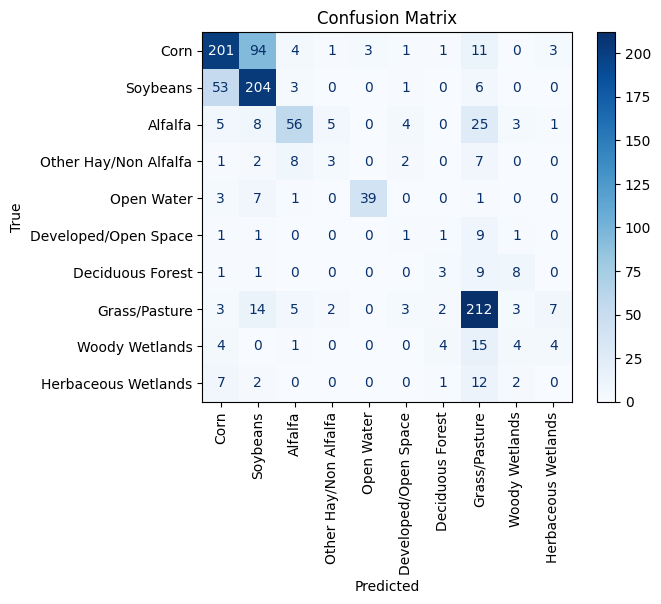

In [53]:
cnf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=class_names)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted")
disp.ax_.set_xticklabels(class_names, rotation=90)
disp.ax_.set_ylabel("True")

In [54]:
per_class_precision = precision_score(y_test, y_pred, average=None, zero_division=0)
per_class_recall = recall_score(y_test, y_pred, average=None, zero_division=0)
per_class_f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

rows = []
for class_index in range(len(class_names)):
    class_name = class_names[class_index]

    class_num = encoder.inverse_transform([class_index])[0]
    n_train = train_val_counts[class_num]
    n_test = test_val_counts[class_num]

    precision = per_class_precision[class_index]
    recall = per_class_recall[class_index]
    f1 = per_class_f1[class_index]

    rows.append(
        {
            "class_name": class_name,
            "n_train": n_train,
            "n_test": n_test,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
    )
pd.DataFrame(rows).sort_values(by="f1", ascending=False).reset_index(drop=True).round(2)

,class_name,n_train,n_test,precision,recall,f1
0,Open Water,5,51,0.93,0.76,0.84
1,Grass/Pasture,28,251,0.69,0.84,0.76
2,Soybeans,30,267,0.61,0.76,0.68
3,Corn,35,319,0.72,0.63,0.67
4,Alfalfa,12,107,0.72,0.52,0.61
5,Other Hay/Non Alfalfa,2,23,0.27,0.13,0.18
6,Deciduous Forest,2,22,0.25,0.14,0.18
7,Woody Wetlands,4,32,0.19,0.12,0.15
8,Developed/Open Space,2,14,0.08,0.07,0.08
9,Herbaceous Wetlands,3,24,0.00,0.00,0.00


Some things to note:
- It makes sense that our model is performing really well on "fields" that have a majority class label of "water" -- this _should_ be a very easy task to learn
- For the crop classes: Soybeans, Corn, Alfalfa we see F1 scores between 0.6 and 0.7 -- this is with relatively few ~30 labeled examples per class
- Looking at the confusion matrix we can see that the model is struggling to distinguish between Soybeans and Corn, which makes sense? TODO and over predicting on Grass/Pasture

### How does performance change with more labels?

In [61]:
# run experiments with varying amount of training data then plot the f1 score for corn and soybeans over training fraction
import matplotlib.pyplot as plt

xs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
ys_corn = []
ys_soybean = []
for pct in xs:
    corn_f1s = []
    soybean_f1s = []
    for seed in tqdm(range(10), desc=f"Running experiment with train fraction {pct}"):

        y_pred, y_test, class_names = run_experiment(
            features_per_field=features_per_field,
            majority_class_vals=majority_class_vals,
            min_fields=10,
            train_fraction=pct,
            random_state=seed,
            verbose=False
        )

        per_class_f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
        corn_f1 = per_class_f1[class_names.index("Corn")]
        soybean_f1 = per_class_f1[class_names.index("Soybeans")]
        corn_f1s.append(corn_f1)
        soybean_f1s.append(soybean_f1)
    ys_corn.append(corn_f1s)
    ys_soybean.append(soybean_f1s)

xs = np.array(xs)
ys_corn = np.array(ys_corn)
ys_soybean = np.array(ys_soybean)

Running experiment with train fraction 0.5: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


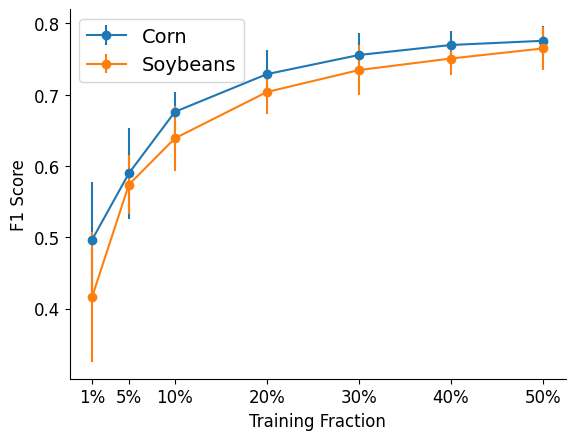

In [67]:
plt.figure()
ax = plt.gca()
plt.errorbar(xs, ys_corn.mean(axis=1), yerr=ys_corn.std(axis=1), label="Corn", marker="o")
plt.errorbar(xs, ys_soybean.mean(axis=1), yerr=ys_soybean.std(axis=1), label="Soybeans", marker="o")
plt.xlabel("Training Fraction", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(xs, [f"{x*100:.0f}%" for x in xs], fontsize=12)
plt.legend(fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
plt.close()

<a name="results-and-discussion"></a>
# Results & Discussion

In this section, describe your results. Briefly describe the performance metrics and cross validation techniques used.

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

Finally, include a discussion on the limitations and important takeaways from the exercise. Relate the takeaways back to the user learning outcomes.

## Limitations
*   ML algorithms and datasets can reinforce or reflect unfair biases. Reflect on the potential biases in the dataset and/or analysis presented in your tutorial, including its potential societal impact, and discuss how you might go about addressing this challenge.

* Additionally, we encourage authors to highlight and reflect upon any data gaps that may be present along with suggested pathways to overcome these gaps as well as steps for further development and usage. To assist with identifying the types of data gaps that could exist please see CCAI's [datagaps taxonomy](https://www.climatechange.ai/dev/datagaps/info#taxonomy-of-data-gaps).

## Next Steps
*   What do you imagine would be the next steps for your readers after finishing your tutorial?
*   Discuss other potential climate-related applications for the method or tool discussed in the tutorial.
*   Do you know of other climate-related datasets similar to the one used in this tutorial? List them here.

<a name="references"></a>
# References

*   EarthCube Notebook Template: https://github.com/earthcube/NotebookTemplates
*   Earth Engine Community Tutorials Style Guide: https://developers.google.com/earth-engine/tutorials/community/styleguide#colab
*   Google Cloud Community Tutorial Style Guide: https://cloud.google.com/community/tutorials/styleguide
*   Rule A, Birmingham A, Zuniga C, Altintas I, Huang S-C, Knight R, et al. (2019) Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks. PLoS Comput Biol 15(7): e1007007. https://doi.org/10.1371/journal.pcbi.1007007
* Wilke, C. Fundamentals of Data Visualization: https://clauswilke.com/dataviz/
* Cookie Cutter Data Science: https://cookiecutter-data-science.drivendata.org/
* CCAI Taxonomy of Data Gaps: https://www.climatechange.ai/dev/datagaps/info#taxonomy-of-data-gaps



# Submitting the Tutorial
*(Please remove this section from your final tutorial submission.)*

When submitting your tutorial notebook please follow a naming convention that shows the submission version and title. We adapt the convention utilized in [cookie cutter data science](https://cookiecutter-data-science.drivendata.org/opinions/#notebooks-are-for-exploration-and-communication-source-files-are-for-repetition) and suggest the format `<version>-<title>.ipynb` (e.g., `1.0-spatiotemporal-analysis-of-coastal-sargassum.ipynb`).

For a complete tutorial submission you are required to submit:


1.   `<version>-<title>.ipynb`
2.   `requirements.txt`



If you are using Google Colab, make sure to change the permissions by clicking "Share" (upper right corner of the notebook) >> Change permissions to "Anyone on the internet with this link can comment".

For additional questions, please feel free to contact:
*   climatechangeai.neurips2025@gmail.com
*   tutorials@climatechange.ai